In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='2'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV1,
    CreateProfileListJson,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataInRageV1, 
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1-jsons')
ORIGINAL_PROFILE_LIST_JSON = os.path.join(DATASET_DIR, f'profiles-v1', f'profile_list_v1.json')
INPUT_CSV_PATH = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1.csv')
LABEL = f'profiles_v1_experiment_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v1_experiment_2_20250326_0344


In [3]:
# * * * * * * * * * * * * * * * *
# Lood Temp Data + Profile List
# * * * * * * * * * * * * * * * *
temp_data, profile_list = LoadTemperatureDataInRageV1(INPUT_CSV_PATH, DEVICE)

Loading Profiles: 3753874it [03:33, 17607.85it/s]


In [4]:
# * * * * * * * * * * * * * * * *
# Save Profile List
# * * * * * * * * * * * * * * * *
CreateProfileListJson(os.path.join(model_dir, "profile_list_v1_in_range.json"), profile_list)

Saved figure to /workspace/outputs/profiles_v1_experiment_2_20250326_0344/density_plot.png


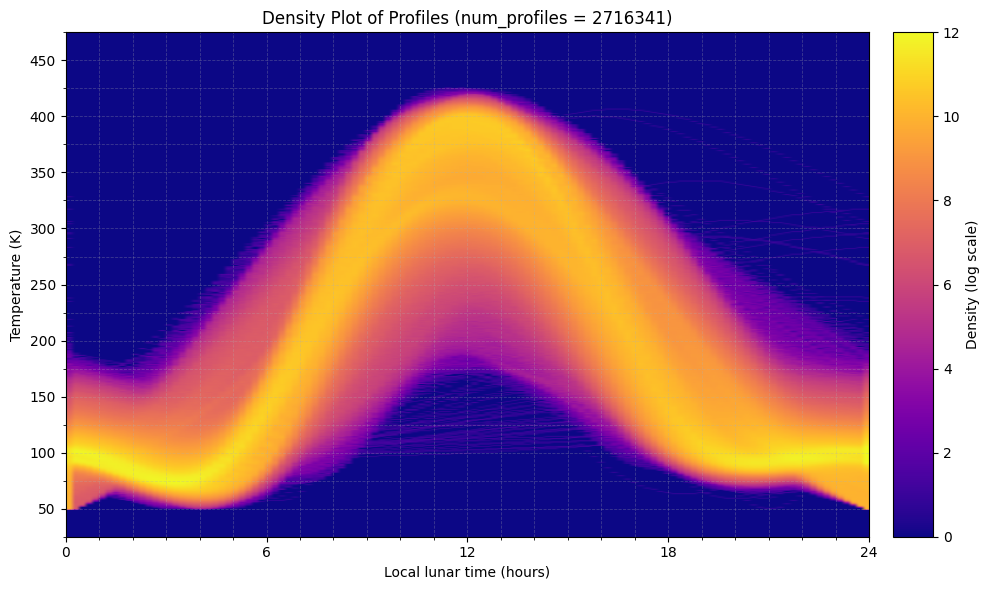

In [5]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [6]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v1_experiment_2_20250326_0344/histogram_max_temp.png


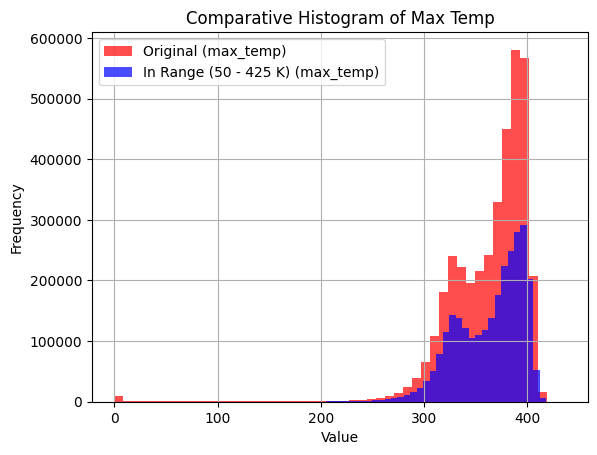

Saved figure to /workspace/outputs/profiles_v1_experiment_2_20250326_0344/histogram_min_temp.png


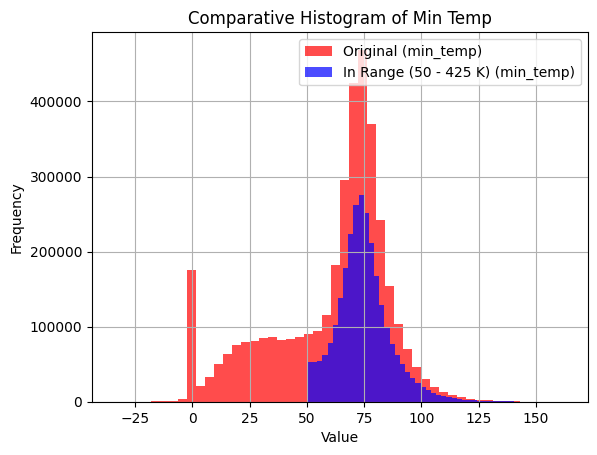

Saved figure to /workspace/outputs/profiles_v1_experiment_2_20250326_0344/histogram_mean_temp.png


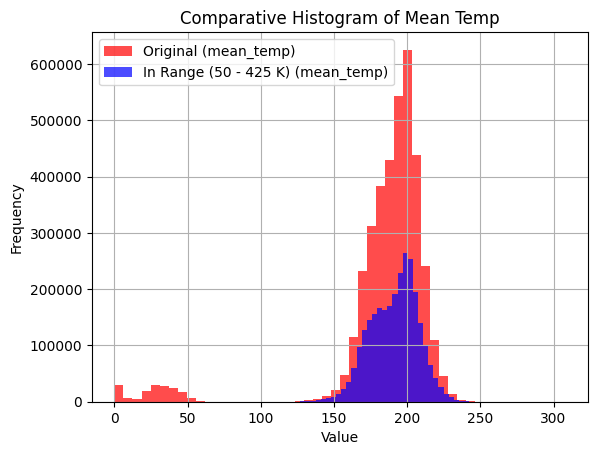

Saved figure to /workspace/outputs/profiles_v1_experiment_2_20250326_0344/histogram_std_temp.png


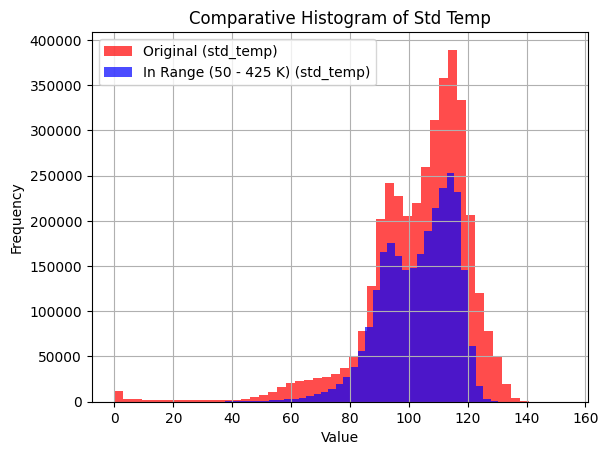

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV1(PROFILES_DIR, original_profile_list)
statistics_in_range = CollectStatisticsFromProfilesV1(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_in_range, labels=("Original", "In Range (50 - 425 K)"), output_dir=model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 191.0980
STD: 105.1539
Min Temp: 50.0000
Max Temp: 424.9460
Datasets:
Training Data: 1901438
Validation Data: 543268
Test Data: 271635


In [9]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 9508/9508 [05:07<00:00, 30.94it/s, best_loss=0.5497]


[Training] Epoch 1/100, L1 Loss: 0.5591, L2 Loss: 0.5597, KL Loss: 0.6267, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 2717/2717 [00:26<00:00, 103.54it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5218, Val L2 Loss: 0.5161, Val KL Loss: 0.6067
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_2_20250326_0344'


[Training] Epoch 2/100: 100%|██████████| 9508/9508 [05:06<00:00, 30.97it/s, best_loss=0.5428]


[Training] Epoch 2/100, L1 Loss: 0.5497, L2 Loss: 0.5469, KL Loss: 0.6343, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 2717/2717 [00:27<00:00, 99.53it/s] 


[Validation] Epoch 2/100, Val L1 Loss: 0.5029, Val L2 Loss: 0.4998, Val KL Loss: 0.6490
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_2_20250326_0344'


[Training] Epoch 3/100: 100%|██████████| 9508/9508 [05:07<00:00, 30.89it/s, best_loss=0.5260]


[Training] Epoch 3/100, L1 Loss: 0.5487, L2 Loss: 0.5457, KL Loss: 0.6361, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 2717/2717 [00:27<00:00, 99.79it/s] 


[Validation] Epoch 3/100, Val L1 Loss: 0.5059, Val L2 Loss: 0.5025, Val KL Loss: 0.6369


[Training] Epoch 4/100: 100%|██████████| 9508/9508 [05:09<00:00, 30.73it/s, best_loss=0.5401]


[Training] Epoch 4/100, L1 Loss: 0.5487, L2 Loss: 0.5457, KL Loss: 0.6359, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 2717/2717 [00:26<00:00, 100.79it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5148, Val L2 Loss: 0.5094, Val KL Loss: 0.6141


[Training] Epoch 5/100: 100%|██████████| 9508/9508 [05:10<00:00, 30.64it/s, best_loss=0.5452]


[Training] Epoch 5/100, L1 Loss: 0.5487, L2 Loss: 0.5457, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 2717/2717 [00:27<00:00, 100.17it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5065, Val L2 Loss: 0.5031, Val KL Loss: 0.6302


[Training] Epoch 6/100: 100%|██████████| 9508/9508 [05:09<00:00, 30.74it/s, best_loss=0.5363]


[Training] Epoch 6/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 2717/2717 [00:28<00:00, 93.74it/s] 


[Validation] Epoch 6/100, Val L1 Loss: 0.5104, Val L2 Loss: 0.5060, Val KL Loss: 0.6218


[Training] Epoch 7/100: 100%|██████████| 9508/9508 [05:08<00:00, 30.81it/s, best_loss=0.5328]


[Training] Epoch 7/100, L1 Loss: 0.5486, L2 Loss: 0.5454, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 2717/2717 [00:27<00:00, 97.36it/s] 


[Validation] Epoch 7/100, Val L1 Loss: 0.5032, Val L2 Loss: 0.5005, Val KL Loss: 0.6368


[Training] Epoch 8/100: 100%|██████████| 9508/9508 [05:03<00:00, 31.34it/s, best_loss=0.5423]


[Training] Epoch 8/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 2717/2717 [00:25<00:00, 107.45it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5031, Val L2 Loss: 0.5005, Val KL Loss: 0.6437


[Training] Epoch 9/100: 100%|██████████| 9508/9508 [04:58<00:00, 31.85it/s, best_loss=0.5437]


[Training] Epoch 9/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 2717/2717 [00:25<00:00, 107.99it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5039, Val L2 Loss: 0.5010, Val KL Loss: 0.6427


[Training] Epoch 10/100: 100%|██████████| 9508/9508 [04:58<00:00, 31.82it/s, best_loss=0.5362]


[Training] Epoch 10/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 2717/2717 [00:24<00:00, 108.98it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5085, Val L2 Loss: 0.5041, Val KL Loss: 0.6329


[Training] Epoch 11/100: 100%|██████████| 9508/9508 [04:59<00:00, 31.74it/s, best_loss=0.5376]


[Training] Epoch 11/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 2717/2717 [00:24<00:00, 108.95it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5029, Val L2 Loss: 0.5003, Val KL Loss: 0.6443
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_2_20250326_0344'


[Training] Epoch 12/100: 100%|██████████| 9508/9508 [04:59<00:00, 31.75it/s, best_loss=0.5328]


[Training] Epoch 12/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.08it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5094, Val L2 Loss: 0.5052, Val KL Loss: 0.6235


[Training] Epoch 13/100: 100%|██████████| 9508/9508 [05:00<00:00, 31.69it/s, best_loss=0.5253]


[Training] Epoch 13/100, L1 Loss: 0.5487, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 2717/2717 [00:25<00:00, 106.38it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5052, Val L2 Loss: 0.5021, Val KL Loss: 0.6385


[Training] Epoch 14/100: 100%|██████████| 9508/9508 [04:57<00:00, 31.93it/s, best_loss=0.5431]


[Training] Epoch 14/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.90it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5065, Val L2 Loss: 0.5031, Val KL Loss: 0.6371


[Training] Epoch 15/100: 100%|██████████| 9508/9508 [04:57<00:00, 31.95it/s, best_loss=0.5388]


[Training] Epoch 15/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.71it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5106, Val L2 Loss: 0.5060, Val KL Loss: 0.6247


[Training] Epoch 16/100: 100%|██████████| 9508/9508 [04:57<00:00, 31.94it/s, best_loss=0.5341]


[Training] Epoch 16/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.07it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5063, Val L2 Loss: 0.5025, Val KL Loss: 0.6391


[Training] Epoch 17/100: 100%|██████████| 9508/9508 [04:58<00:00, 31.89it/s, best_loss=0.5449]


[Training] Epoch 17/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 2717/2717 [00:25<00:00, 107.79it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5094, Val L2 Loss: 0.5051, Val KL Loss: 0.6279


[Training] Epoch 18/100: 100%|██████████| 9508/9508 [04:58<00:00, 31.89it/s, best_loss=0.5380]


[Training] Epoch 18/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 2717/2717 [00:25<00:00, 108.56it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5084, Val L2 Loss: 0.5045, Val KL Loss: 0.6264


[Training] Epoch 19/100: 100%|██████████| 9508/9508 [04:59<00:00, 31.77it/s, best_loss=0.5255]


[Training] Epoch 19/100, L1 Loss: 0.5485, L2 Loss: 0.5454, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 2717/2717 [00:25<00:00, 107.45it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5092, Val L2 Loss: 0.5049, Val KL Loss: 0.6323


[Training] Epoch 20/100: 100%|██████████| 9508/9508 [04:58<00:00, 31.87it/s, best_loss=0.5465]


[Training] Epoch 20/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 2717/2717 [00:24<00:00, 113.07it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5083, Val L2 Loss: 0.5042, Val KL Loss: 0.6300


[Training] Epoch 21/100: 100%|██████████| 9508/9508 [04:57<00:00, 31.94it/s, best_loss=0.5344]


[Training] Epoch 21/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 2717/2717 [00:24<00:00, 112.47it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5086, Val L2 Loss: 0.5045, Val KL Loss: 0.6287


[Training] Epoch 22/100: 100%|██████████| 9508/9508 [04:59<00:00, 31.71it/s, best_loss=0.5426]


[Training] Epoch 22/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 2717/2717 [00:23<00:00, 113.51it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5065, Val L2 Loss: 0.5030, Val KL Loss: 0.6363


[Training] Epoch 23/100: 100%|██████████| 9508/9508 [04:59<00:00, 31.75it/s, best_loss=0.5413]


[Training] Epoch 23/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 2717/2717 [00:25<00:00, 106.90it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5133, Val L2 Loss: 0.5081, Val KL Loss: 0.6138


[Training] Epoch 24/100: 100%|██████████| 9508/9508 [04:58<00:00, 31.81it/s, best_loss=0.5486]


[Training] Epoch 24/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.87it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5047, Val L2 Loss: 0.5019, Val KL Loss: 0.6413


[Training] Epoch 25/100: 100%|██████████| 9508/9508 [04:59<00:00, 31.70it/s, best_loss=0.5324]


[Training] Epoch 25/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 2717/2717 [00:25<00:00, 105.14it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5076, Val L2 Loss: 0.5040, Val KL Loss: 0.6324


[Training] Epoch 26/100: 100%|██████████| 9508/9508 [04:58<00:00, 31.87it/s, best_loss=0.5348]


[Training] Epoch 26/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.76it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5070, Val L2 Loss: 0.5032, Val KL Loss: 0.6420


[Training] Epoch 27/100: 100%|██████████| 9508/9508 [04:59<00:00, 31.72it/s, best_loss=0.5513]


[Training] Epoch 27/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 2717/2717 [00:25<00:00, 108.23it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5126, Val L2 Loss: 0.5076, Val KL Loss: 0.6149


[Training] Epoch 28/100: 100%|██████████| 9508/9508 [04:58<00:00, 31.88it/s, best_loss=0.5301]


[Training] Epoch 28/100, L1 Loss: 0.5485, L2 Loss: 0.5454, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.68it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5066, Val L2 Loss: 0.5029, Val KL Loss: 0.6328


[Training] Epoch 29/100: 100%|██████████| 9508/9508 [05:00<00:00, 31.63it/s, best_loss=0.5366]


[Training] Epoch 29/100, L1 Loss: 0.5487, L2 Loss: 0.5457, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 2717/2717 [00:25<00:00, 108.28it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5042, Val L2 Loss: 0.5010, Val KL Loss: 0.6452


[Training] Epoch 30/100: 100%|██████████| 9508/9508 [04:59<00:00, 31.76it/s, best_loss=0.5398]


[Training] Epoch 30/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.95it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5121, Val L2 Loss: 0.5068, Val KL Loss: 0.6236


[Training] Epoch 31/100: 100%|██████████| 9508/9508 [04:57<00:00, 31.97it/s, best_loss=0.5400]


[Training] Epoch 31/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 2717/2717 [00:25<00:00, 108.32it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5124, Val L2 Loss: 0.5079, Val KL Loss: 0.6182


[Training] Epoch 32/100: 100%|██████████| 9508/9508 [04:59<00:00, 31.74it/s, best_loss=0.5385]


[Training] Epoch 32/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 2717/2717 [00:25<00:00, 106.87it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5104, Val L2 Loss: 0.5057, Val KL Loss: 0.6226


[Training] Epoch 33/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.20it/s, best_loss=0.5332]


[Training] Epoch 33/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 2717/2717 [00:25<00:00, 108.20it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5103, Val L2 Loss: 0.5059, Val KL Loss: 0.6258


[Training] Epoch 34/100: 100%|██████████| 9508/9508 [04:57<00:00, 31.96it/s, best_loss=0.5405]


[Training] Epoch 34/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 2717/2717 [00:23<00:00, 113.82it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5116, Val L2 Loss: 0.5073, Val KL Loss: 0.6219


[Training] Epoch 35/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.04it/s, best_loss=0.5309]


[Training] Epoch 35/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 2717/2717 [00:24<00:00, 113.09it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5100, Val L2 Loss: 0.5056, Val KL Loss: 0.6295


[Training] Epoch 36/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.17it/s, best_loss=0.5430]


[Training] Epoch 36/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 2717/2717 [00:23<00:00, 114.34it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5101, Val L2 Loss: 0.5057, Val KL Loss: 0.6262


[Training] Epoch 37/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.02it/s, best_loss=0.5498]


[Training] Epoch 37/100, L1 Loss: 0.5485, L2 Loss: 0.5454, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.31it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5098, Val L2 Loss: 0.5055, Val KL Loss: 0.6306


[Training] Epoch 38/100: 100%|██████████| 9508/9508 [04:57<00:00, 32.00it/s, best_loss=0.5421]


[Training] Epoch 38/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.18it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5051, Val L2 Loss: 0.5019, Val KL Loss: 0.6411


[Training] Epoch 39/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.18it/s, best_loss=0.5280]


[Training] Epoch 39/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.34it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5052, Val L2 Loss: 0.5021, Val KL Loss: 0.6371


[Training] Epoch 40/100: 100%|██████████| 9508/9508 [04:58<00:00, 31.84it/s, best_loss=0.5458]


[Training] Epoch 40/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 2717/2717 [00:24<00:00, 113.12it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5040, Val L2 Loss: 0.5009, Val KL Loss: 0.6420


[Training] Epoch 41/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.07it/s, best_loss=0.5373]


[Training] Epoch 41/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 2717/2717 [00:24<00:00, 113.10it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5084, Val L2 Loss: 0.5045, Val KL Loss: 0.6248


[Training] Epoch 42/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.15it/s, best_loss=0.5462]


[Training] Epoch 42/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.88it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5080, Val L2 Loss: 0.5041, Val KL Loss: 0.6320


[Training] Epoch 43/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.08it/s, best_loss=0.5364]


[Training] Epoch 43/100, L1 Loss: 0.5487, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.88it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5115, Val L2 Loss: 0.5068, Val KL Loss: 0.6200


[Training] Epoch 44/100: 100%|██████████| 9508/9508 [04:57<00:00, 31.98it/s, best_loss=0.5411]


[Training] Epoch 44/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.27it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5087, Val L2 Loss: 0.5045, Val KL Loss: 0.6292


[Training] Epoch 45/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.03it/s, best_loss=0.5262]


[Training] Epoch 45/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 2717/2717 [00:24<00:00, 112.06it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5098, Val L2 Loss: 0.5052, Val KL Loss: 0.6290


[Training] Epoch 46/100: 100%|██████████| 9508/9508 [04:57<00:00, 31.91it/s, best_loss=0.5384]


[Training] Epoch 46/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 2717/2717 [00:23<00:00, 113.40it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5089, Val L2 Loss: 0.5047, Val KL Loss: 0.6257


[Training] Epoch 47/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.18it/s, best_loss=0.5400]


[Training] Epoch 47/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 2717/2717 [00:23<00:00, 114.47it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5027, Val L2 Loss: 0.5000, Val KL Loss: 0.6496
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_2_20250326_0344'


[Training] Epoch 48/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.13it/s, best_loss=0.5480]


[Training] Epoch 48/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.98it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5032, Val L2 Loss: 0.5005, Val KL Loss: 0.6427


[Training] Epoch 49/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.17it/s, best_loss=0.5207]


[Training] Epoch 49/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.65it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5045, Val L2 Loss: 0.5014, Val KL Loss: 0.6440


[Training] Epoch 50/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.23it/s, best_loss=0.5158]


[Training] Epoch 50/100, L1 Loss: 0.5485, L2 Loss: 0.5454, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.66it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5026, Val L2 Loss: 0.5000, Val KL Loss: 0.6432
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_2_20250326_0344'


[Training] Epoch 51/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.05it/s, best_loss=0.5370]


[Training] Epoch 51/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 2717/2717 [00:24<00:00, 112.68it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5060, Val L2 Loss: 0.5023, Val KL Loss: 0.6431


[Training] Epoch 52/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.10it/s, best_loss=0.5407]


[Training] Epoch 52/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.22it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5081, Val L2 Loss: 0.5044, Val KL Loss: 0.6311


[Training] Epoch 53/100: 100%|██████████| 9508/9508 [04:58<00:00, 31.82it/s, best_loss=0.5379]


[Training] Epoch 53/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.28it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5044, Val L2 Loss: 0.5015, Val KL Loss: 0.6433


[Training] Epoch 54/100: 100%|██████████| 9508/9508 [04:57<00:00, 32.00it/s, best_loss=0.5500]


[Training] Epoch 54/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.89it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5055, Val L2 Loss: 0.5024, Val KL Loss: 0.6335


[Training] Epoch 55/100: 100%|██████████| 9508/9508 [04:57<00:00, 31.92it/s, best_loss=0.5408]


[Training] Epoch 55/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 2717/2717 [00:24<00:00, 112.75it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5084, Val L2 Loss: 0.5045, Val KL Loss: 0.6257


[Training] Epoch 56/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.08it/s, best_loss=0.4982]


[Training] Epoch 56/100, L1 Loss: 0.5485, L2 Loss: 0.5454, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 2717/2717 [00:24<00:00, 108.73it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5087, Val L2 Loss: 0.5047, Val KL Loss: 0.6298


[Training] Epoch 57/100: 100%|██████████| 9508/9508 [04:54<00:00, 32.25it/s, best_loss=0.5435]


[Training] Epoch 57/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.82it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.5139, Val L2 Loss: 0.5084, Val KL Loss: 0.6153


[Training] Epoch 58/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.21it/s, best_loss=0.5200]


[Training] Epoch 58/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.14it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5110, Val L2 Loss: 0.5064, Val KL Loss: 0.6200


[Training] Epoch 59/100: 100%|██████████| 9508/9508 [04:57<00:00, 32.00it/s, best_loss=0.5401]


[Training] Epoch 59/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.60it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5126, Val L2 Loss: 0.5074, Val KL Loss: 0.6213


[Training] Epoch 60/100: 100%|██████████| 9508/9508 [04:54<00:00, 32.28it/s, best_loss=0.5211]


[Training] Epoch 60/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 2717/2717 [00:24<00:00, 112.11it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5096, Val L2 Loss: 0.5055, Val KL Loss: 0.6314


[Training] Epoch 61/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.22it/s, best_loss=0.5404]


[Training] Epoch 61/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 2717/2717 [00:23<00:00, 113.42it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5056, Val L2 Loss: 0.5020, Val KL Loss: 0.6351


[Training] Epoch 62/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.14it/s, best_loss=0.5394]


[Training] Epoch 62/100, L1 Loss: 0.5485, L2 Loss: 0.5454, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 2717/2717 [00:23<00:00, 113.22it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5087, Val L2 Loss: 0.5047, Val KL Loss: 0.6336


[Training] Epoch 63/100: 100%|██████████| 9508/9508 [04:53<00:00, 32.37it/s, best_loss=0.5447]


[Training] Epoch 63/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.37it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5064, Val L2 Loss: 0.5028, Val KL Loss: 0.6273


[Training] Epoch 64/100: 100%|██████████| 9508/9508 [04:57<00:00, 31.98it/s, best_loss=0.5325]


[Training] Epoch 64/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 2717/2717 [00:23<00:00, 113.96it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5065, Val L2 Loss: 0.5029, Val KL Loss: 0.6340


[Training] Epoch 65/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.14it/s, best_loss=0.5185]


[Training] Epoch 65/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 2717/2717 [00:23<00:00, 113.44it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5035, Val L2 Loss: 0.5006, Val KL Loss: 0.6428


[Training] Epoch 66/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.12it/s, best_loss=0.5350]


[Training] Epoch 66/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.94it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5083, Val L2 Loss: 0.5043, Val KL Loss: 0.6359


[Training] Epoch 67/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.07it/s, best_loss=0.5239]


[Training] Epoch 67/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 2717/2717 [00:23<00:00, 113.46it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5031, Val L2 Loss: 0.5003, Val KL Loss: 0.6469


[Training] Epoch 68/100: 100%|██████████| 9508/9508 [04:54<00:00, 32.29it/s, best_loss=0.5437]


[Training] Epoch 68/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.46it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5044, Val L2 Loss: 0.5014, Val KL Loss: 0.6463


[Training] Epoch 69/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.23it/s, best_loss=0.5256]


[Training] Epoch 69/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.99it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5044, Val L2 Loss: 0.5016, Val KL Loss: 0.6364


[Training] Epoch 70/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.02it/s, best_loss=0.4662]


[Training] Epoch 70/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 2717/2717 [00:23<00:00, 113.27it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5099, Val L2 Loss: 0.5058, Val KL Loss: 0.6299


[Training] Epoch 71/100: 100%|██████████| 9508/9508 [04:53<00:00, 32.37it/s, best_loss=0.5422]


[Training] Epoch 71/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.10it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5068, Val L2 Loss: 0.5031, Val KL Loss: 0.6329


[Training] Epoch 72/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.04it/s, best_loss=0.5474]


[Training] Epoch 72/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.85it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5128, Val L2 Loss: 0.5077, Val KL Loss: 0.6226


[Training] Epoch 73/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.09it/s, best_loss=0.5397]


[Training] Epoch 73/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.73it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5057, Val L2 Loss: 0.5025, Val KL Loss: 0.6372


[Training] Epoch 74/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.12it/s, best_loss=0.5156]


[Training] Epoch 74/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 2717/2717 [00:24<00:00, 113.01it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5130, Val L2 Loss: 0.5078, Val KL Loss: 0.6173


[Training] Epoch 75/100: 100%|██████████| 9508/9508 [04:57<00:00, 31.98it/s, best_loss=0.5319]


[Training] Epoch 75/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.85it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5092, Val L2 Loss: 0.5052, Val KL Loss: 0.6281


[Training] Epoch 76/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.13it/s, best_loss=0.5446]


[Training] Epoch 76/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.89it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5022, Val L2 Loss: 0.4996, Val KL Loss: 0.6491
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_2_20250326_0344'


[Training] Epoch 77/100: 100%|██████████| 9508/9508 [04:54<00:00, 32.27it/s, best_loss=0.5351]


[Training] Epoch 77/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 2717/2717 [00:23<00:00, 114.40it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5116, Val L2 Loss: 0.5068, Val KL Loss: 0.6231


[Training] Epoch 78/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.04it/s, best_loss=0.5277]


[Training] Epoch 78/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.63it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5114, Val L2 Loss: 0.5067, Val KL Loss: 0.6247


[Training] Epoch 79/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.04it/s, best_loss=0.5421]


[Training] Epoch 79/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.54it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5092, Val L2 Loss: 0.5049, Val KL Loss: 0.6248


[Training] Epoch 80/100: 100%|██████████| 9508/9508 [04:55<00:00, 32.14it/s, best_loss=0.5446]


[Training] Epoch 80/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.69it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5135, Val L2 Loss: 0.5083, Val KL Loss: 0.6178


[Training] Epoch 81/100: 100%|██████████| 9508/9508 [04:58<00:00, 31.87it/s, best_loss=0.5292]


[Training] Epoch 81/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 2717/2717 [00:24<00:00, 111.49it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.5042, Val L2 Loss: 0.5012, Val KL Loss: 0.6391


[Training] Epoch 82/100: 100%|██████████| 9508/9508 [04:57<00:00, 31.97it/s, best_loss=0.5243]


[Training] Epoch 82/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 2717/2717 [00:24<00:00, 108.75it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5038, Val L2 Loss: 0.5010, Val KL Loss: 0.6433


[Training] Epoch 83/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.04it/s, best_loss=0.5297]


[Training] Epoch 83/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 2717/2717 [00:24<00:00, 108.72it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5046, Val L2 Loss: 0.5017, Val KL Loss: 0.6402


[Training] Epoch 84/100: 100%|██████████| 9508/9508 [04:54<00:00, 32.24it/s, best_loss=0.5276]


[Training] Epoch 84/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.07it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5035, Val L2 Loss: 0.5007, Val KL Loss: 0.6411


[Training] Epoch 85/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.10it/s, best_loss=0.5352]


[Training] Epoch 85/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.73it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5091, Val L2 Loss: 0.5049, Val KL Loss: 0.6328


[Training] Epoch 86/100: 100%|██████████| 9508/9508 [04:56<00:00, 32.11it/s, best_loss=0.5469]


[Training] Epoch 86/100, L1 Loss: 0.5485, L2 Loss: 0.5454, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 2717/2717 [00:24<00:00, 112.85it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5040, Val L2 Loss: 0.5013, Val KL Loss: 0.6353


[Training] Epoch 87/100: 100%|██████████| 9508/9508 [04:57<00:00, 31.95it/s, best_loss=0.5508]


[Training] Epoch 87/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 2717/2717 [00:23<00:00, 113.34it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5098, Val L2 Loss: 0.5058, Val KL Loss: 0.6240


[Training] Epoch 88/100: 100%|██████████| 9508/9508 [04:59<00:00, 31.75it/s, best_loss=0.5272]


[Training] Epoch 88/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.65it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5054, Val L2 Loss: 0.5019, Val KL Loss: 0.6372


[Training] Epoch 89/100: 100%|██████████| 9508/9508 [05:00<00:00, 31.61it/s, best_loss=0.5398]


[Training] Epoch 89/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.92it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5077, Val L2 Loss: 0.5038, Val KL Loss: 0.6341


[Training] Epoch 90/100: 100%|██████████| 9508/9508 [05:01<00:00, 31.58it/s, best_loss=0.5387]


[Training] Epoch 90/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.09it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5058, Val L2 Loss: 0.5025, Val KL Loss: 0.6347


[Training] Epoch 91/100: 100%|██████████| 9508/9508 [05:03<00:00, 31.30it/s, best_loss=0.5328]


[Training] Epoch 91/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 2717/2717 [00:25<00:00, 108.66it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5097, Val L2 Loss: 0.5056, Val KL Loss: 0.6242


[Training] Epoch 92/100: 100%|██████████| 9508/9508 [05:01<00:00, 31.55it/s, best_loss=0.5375]


[Training] Epoch 92/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 2717/2717 [00:24<00:00, 108.97it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5063, Val L2 Loss: 0.5031, Val KL Loss: 0.6305


[Training] Epoch 93/100: 100%|██████████| 9508/9508 [05:00<00:00, 31.59it/s, best_loss=0.5363]


[Training] Epoch 93/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.47it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5049, Val L2 Loss: 0.5017, Val KL Loss: 0.6380


[Training] Epoch 94/100: 100%|██████████| 9508/9508 [05:01<00:00, 31.56it/s, best_loss=0.5433]


[Training] Epoch 94/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.53it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5085, Val L2 Loss: 0.5046, Val KL Loss: 0.6305


[Training] Epoch 95/100: 100%|██████████| 9508/9508 [05:02<00:00, 31.47it/s, best_loss=0.5415]


[Training] Epoch 95/100, L1 Loss: 0.5487, L2 Loss: 0.5457, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.00it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5067, Val L2 Loss: 0.5031, Val KL Loss: 0.6306


[Training] Epoch 96/100: 100%|██████████| 9508/9508 [05:01<00:00, 31.51it/s, best_loss=0.5481]


[Training] Epoch 96/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.94it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5049, Val L2 Loss: 0.5017, Val KL Loss: 0.6347


[Training] Epoch 97/100: 100%|██████████| 9508/9508 [05:02<00:00, 31.48it/s, best_loss=0.5446]


[Training] Epoch 97/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 2717/2717 [00:25<00:00, 108.68it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5099, Val L2 Loss: 0.5056, Val KL Loss: 0.6285


[Training] Epoch 98/100: 100%|██████████| 9508/9508 [05:01<00:00, 31.51it/s, best_loss=0.5412]


[Training] Epoch 98/100, L1 Loss: 0.5486, L2 Loss: 0.5456, KL Loss: 0.6358, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 2717/2717 [00:24<00:00, 110.06it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5036, Val L2 Loss: 0.5008, Val KL Loss: 0.6460


[Training] Epoch 99/100: 100%|██████████| 9508/9508 [05:01<00:00, 31.49it/s, best_loss=0.5290]


[Training] Epoch 99/100, L1 Loss: 0.5487, L2 Loss: 0.5456, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 2717/2717 [00:24<00:00, 109.51it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5092, Val L2 Loss: 0.5048, Val KL Loss: 0.6279


[Training] Epoch 100/100: 100%|██████████| 9508/9508 [05:02<00:00, 31.46it/s, best_loss=0.5393]


[Training] Epoch 100/100, L1 Loss: 0.5486, L2 Loss: 0.5455, KL Loss: 0.6359, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 2717/2717 [00:25<00:00, 107.61it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.5122, Val L2 Loss: 0.5074, Val KL Loss: 0.6215


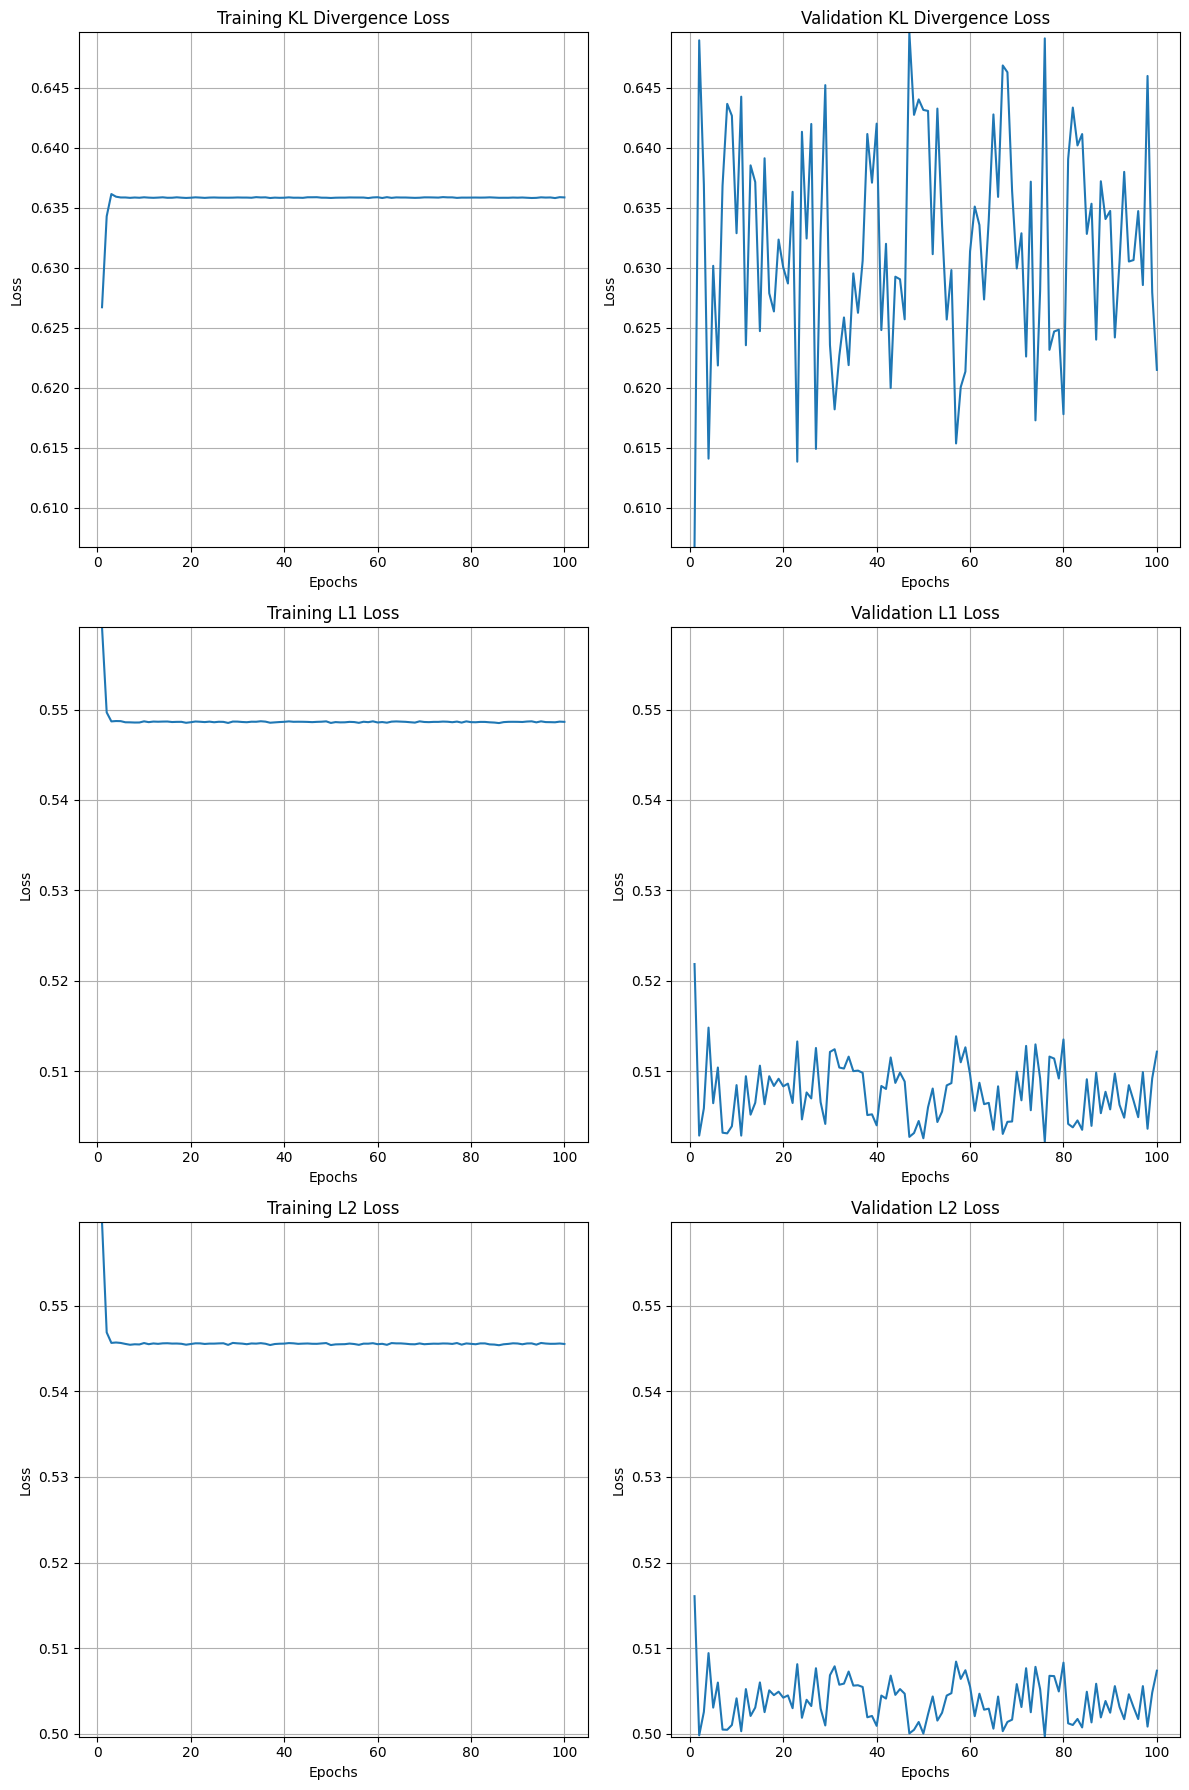

Best Validation Loss in Kelvins:
52.8081 K


In [10]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [11]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 136/136 [00:52<00:00,  2.58it/s]


z0: -0.0180
z1: -0.0531
z2: 0.0147
z3: -0.0110


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 694.32it/s]


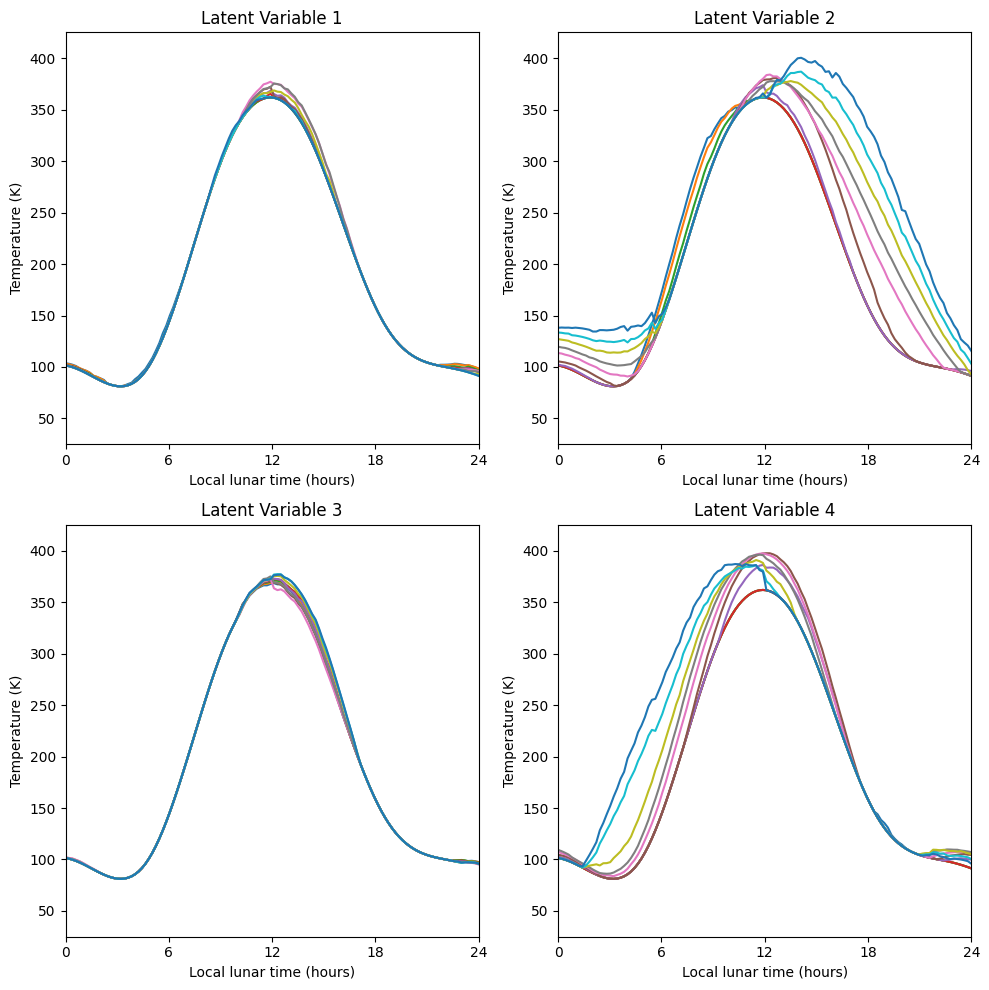

In [12]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)